# Identifying the Goal

The ultimate goal of this project is to show a model capable of predicting accurate a full year's worth of meter readings based only on one year of data.

The idea is that this data can be shown to the building owners after they had switched to green energy to show them the cost savings.

# First look at the data

From using this data already I'm going to be excluding some of data given as this is a large dataset and difficult to run fully.

In [47]:
#Data Cleaning and Organizing
import pandas as pd
import numpy as np
import math
import random
import warnings
warnings.filterwarnings('ignore')

#pre processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

#Modeling
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

In [3]:
#importing the data. Unused data has been commented out.
buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
#test = pd.read_csv('energyCSV/test.csv')
train = pd.read_csv('energyCSV/train.csv')
#weatherTest = pd.read_csv('energyCSV/weather_test.csv')
weatherTrain = pd.read_csv('energyCSV/weather_train.csv')

In [4]:
print(train.info(), weatherTrain.info(), buildMetData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  fl

In [5]:
#this is a cool function that I found from a kaggle user named Alexander Sylvester.
#This code just checks and displays any and all missing information in a df

def getMissingInfo(df):
    numEntries = df.shape[0]*df.shape[1]
    nullEntries = df.isnull().sum().sum()
    percentEmpty = nullEntries/numEntries*100
    numMissing = df.isna().sum()
    percentMissing = numMissing/len(df)*100
    colModes = df.mode().loc[0]
    percentModes = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missingDfValues = pd.DataFrame({'num_missing': numMissing,
                                     'percent_missing': percentMissing, 
                                     'mode': colModes,
                                     'percent_mode':percentModes})
    print('total empty percent:', percentEmpty, '%')
    print('columns that are more than 97% mode:', missingDfValues.loc[missingDfValues['percent_mode']>97].index.values)
    return(missingDfValues)

In [6]:
getMissingInfo(train)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249,0.173802
meter,0,0.0,0,59.659925
timestamp,0,0.0,2016-12-27 22:00:00,0.011723
meter_reading,0,0.0,0,9.269721


In [7]:
getMissingInfo(buildMetData)

total empty percent: 21.486082355647575 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,3,18.909593
building_id,0,0.000000,0,0.069013
primary_use,0,0.000000,Education,37.888199
square_feet,0,0.000000,387638,0.483092
year_built,774,53.416149,1976,3.795721
floor_count,1094,75.500345,1,7.522429


In [8]:
getMissingInfo(weatherTrain)

total empty percent: 10.876365408356566 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,55,0.039350,15,1.947443
cloud_coverage,69173,49.489529,0,24.232863
dew_temperature,113,0.080845,10,1.973915
precip_depth_1_hr,50289,35.979052,0,55.740379
sea_level_pressure,10618,7.596603,1015.2,0.608844
wind_direction,6268,4.484414,0,9.410974
wind_speed,304,0.217496,2.1,10.288825


Quite a bit of data is missing. We'll keep this in mind for when we clean the data.

In [9]:
trainBuild = train.merge(buildMetData, on=['building_id'], how='left')
#making a new df so i dont need to reimport the original data.

trainDis = trainBuild.merge(weatherTrain, on=['site_id','timestamp'], how='left')

In [10]:
#droping some columns to simplify the matrix plot
dropCols = ['timestamp', 'site_id', 'meter', 'meter_reading', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

In [11]:
trainDis = trainDis.drop(dropCols, axis = 1)

My assumption here is that this dataset will not have many variables that depend on each other.

Columns like 'square_feet' don't dictate 'year_built' or 'air_temperature' - and vice versa. But just to be sure, let's check.

In [12]:
trainDis

,building_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature
0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0
1,1,Education,2720,2004.0,NaN,25.0,6.0,20.0
2,2,Education,5376,1991.0,NaN,25.0,6.0,20.0
3,3,Education,23685,2002.0,NaN,25.0,6.0,20.0
4,4,Education,116607,1975.0,NaN,25.0,6.0,20.0
...,...,...,...,...,...,...,...,...
20216095,1444,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6
20216096,1445,Education,4298,NaN,NaN,1.7,NaN,-5.6
20216097,1446,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6
20216098,1447,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6


In [14]:
num = 0
pickSome = []
for i in range(1448):
    num = num + 1
    pickSome.append(num)

n = 10
pickSome = random.sample(pickSome, n)
#picking 10 random 
trainDis = trainDis[  (trainDis['building_id'] == pickSome[0]) 
                    | (trainDis['building_id'] == pickSome[1])
                    | (trainDis['building_id'] == pickSome[2])
                    | (trainDis['building_id'] == pickSome[3])
                    | (trainDis['building_id'] == pickSome[4])
                    | (trainDis['building_id'] == pickSome[5])
                    | (trainDis['building_id'] == pickSome[6])
                    | (trainDis['building_id'] == pickSome[7])
                    | (trainDis['building_id'] == pickSome[8])
                    | (trainDis['building_id'] == pickSome[9])]

In [15]:
trainDis

,building_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature
1,1,Education,2720,2004.0,NaN,25.0,6.0,20.0
31,32,Office,48392,2005.0,NaN,25.0,6.0,20.0
94,96,Lodging/residential,200933,2006.0,NaN,25.0,6.0,20.0
163,153,Office,16092,1965.0,3.0,3.8,NaN,2.4
315,223,Education,261188,NaN,NaN,15.6,6.0,-5.6
...,...,...,...,...,...,...,...,...
20214944,911,Education,239638,NaN,NaN,24.4,0.0,16.1
20214945,911,Education,239638,NaN,NaN,24.4,0.0,16.1
20215513,1198,Education,85164,NaN,NaN,-5.6,4.0,-11.1
20215514,1198,Education,85164,NaN,NaN,-5.6,4.0,-11.1


array([[<AxesSubplot:xlabel='building_id', ylabel='building_id'>,
        <AxesSubplot:xlabel='square_feet', ylabel='building_id'>,
        <AxesSubplot:xlabel='year_built', ylabel='building_id'>,
        <AxesSubplot:xlabel='floor_count', ylabel='building_id'>,
        <AxesSubplot:xlabel='air_temperature', ylabel='building_id'>,
        <AxesSubplot:xlabel='cloud_coverage', ylabel='building_id'>,
        <AxesSubplot:xlabel='dew_temperature', ylabel='building_id'>],
       [<AxesSubplot:xlabel='building_id', ylabel='square_feet'>,
        <AxesSubplot:xlabel='square_feet', ylabel='square_feet'>,
        <AxesSubplot:xlabel='year_built', ylabel='square_feet'>,
        <AxesSubplot:xlabel='floor_count', ylabel='square_feet'>,
        <AxesSubplot:xlabel='air_temperature', ylabel='square_feet'>,
        <AxesSubplot:xlabel='cloud_coverage', ylabel='square_feet'>,
        <AxesSubplot:xlabel='dew_temperature', ylabel='square_feet'>],
       [<AxesSubplot:xlabel='building_id', ylabel='yea

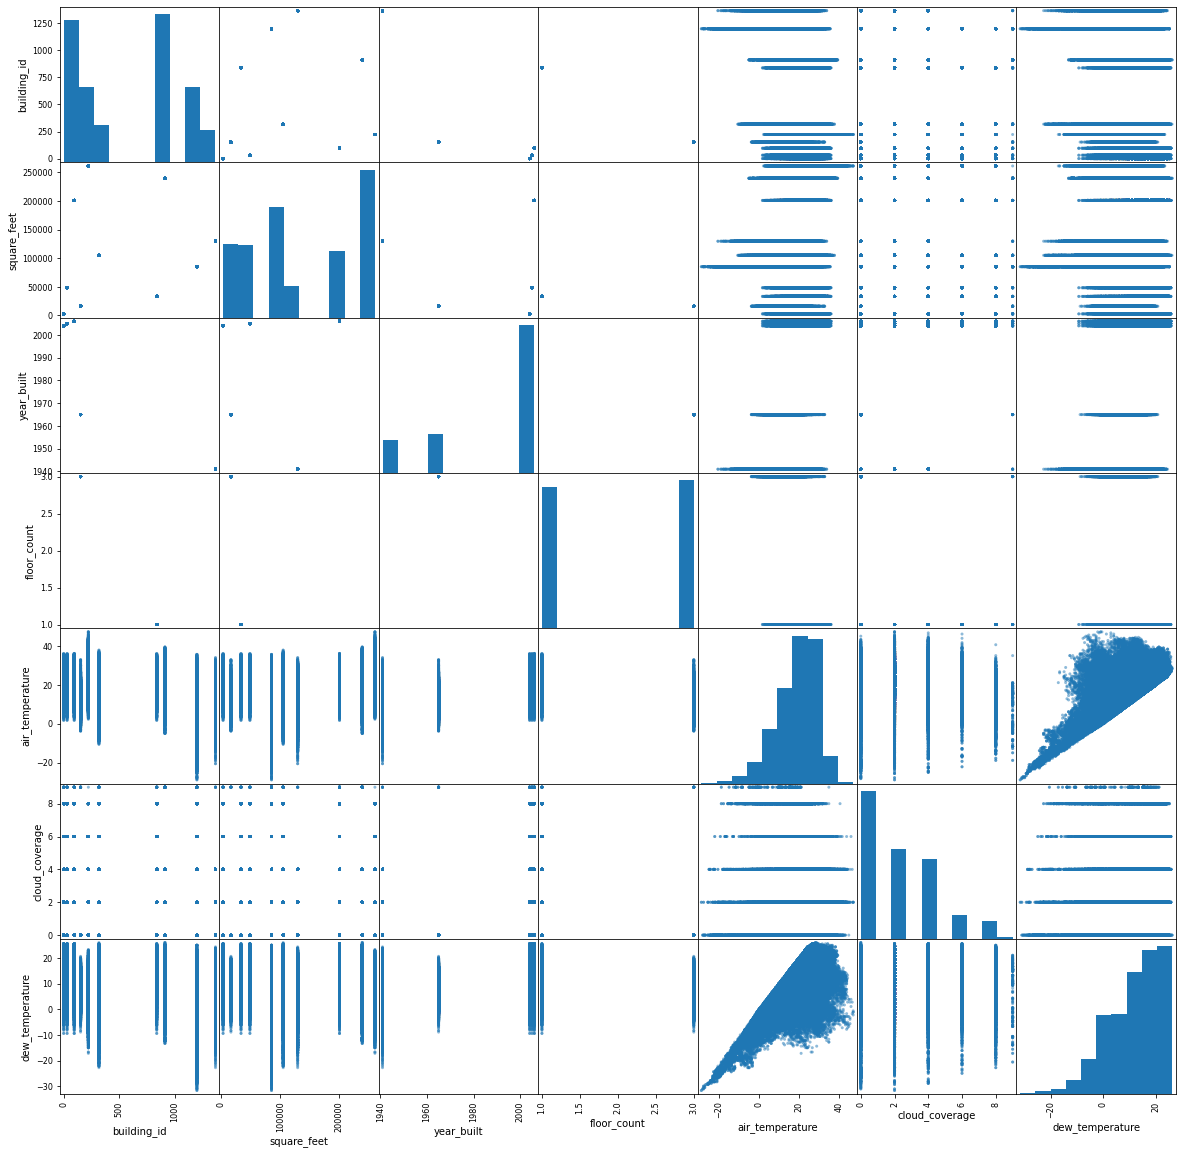

In [16]:
pd.plotting.scatter_matrix(trainDis, figsize = (20, 20))
#plt.savefig('images/plotMatrix')

In [17]:
del trainDis

As suspected. The only two columns with something in common are both weather related ('air_temperature' & 'dew_temperature'). A linear model wouldn't work here so I'm moving forward with decision trees.

# Data cleaning

In [18]:
# Function to reduce the df size
#original code is from Kaggle user Koustav Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
#recategorizing 'timestamp'
train['timestamp'] = pd.to_datetime(train['timestamp'])
weatherTrain['timestamp'] = pd.to_datetime(weatherTrain['timestamp'])

#reducing size
train = reduce_mem_usage(train)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [20]:
weatherTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


First, there are a few columns that are going to cause us trouble later for being a float and may not provide very much in the way of feature importance, so following columns can be dropped.

 - precip_depth_1_hr
 - sea_level_pressure
 - wind_direction
 - wind_speed

In [21]:
dropCols = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
weatherTrain = weatherTrain.drop(dropCols, axis = 1)

As we'd seen before, there is a lot of missing data in this dataset.

(array([   0,    1,    2, ..., 1446, 1447, 1448]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  T

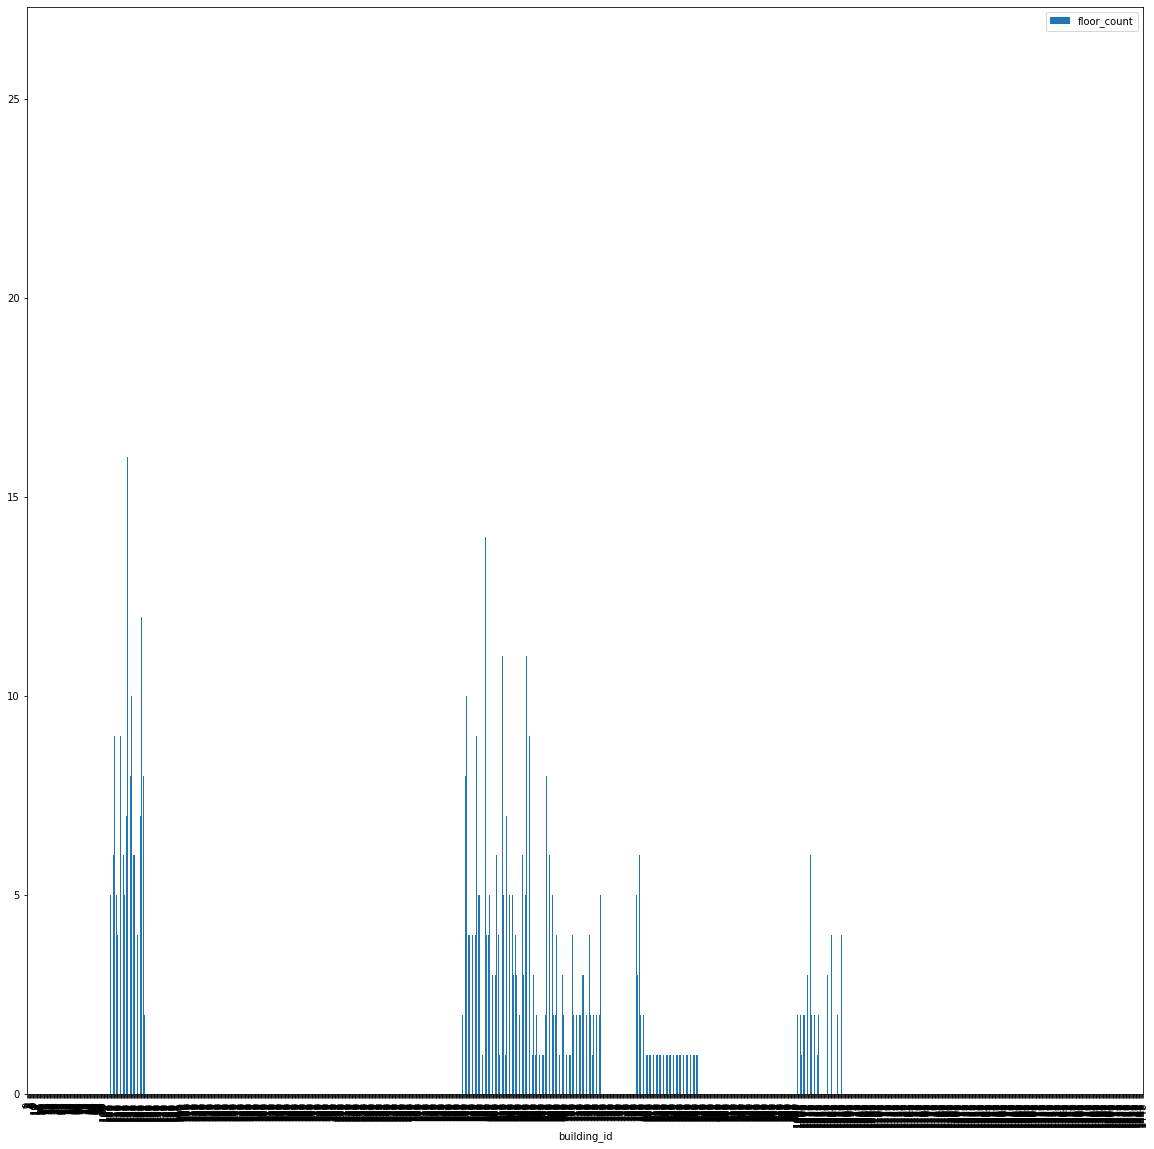

In [22]:
buildMetData.plot(x = 'building_id', y = 'floor_count', kind = 'bar', figsize = (20, 20))
plt.xticks(rotation = 90)
#plt.savefig('images/missingDataFloor')

### buildMetData

buildMetData needs some work done
- missing values need to be dealt with
- primary_use needs to be label encoded

In [23]:
#filling missing data
buildMetData.fillna({'floor_count':1, 'year_built':int(buildMetData['year_built'].mean())}, inplace=True) 

In [24]:
#label encoding
le = LabelEncoder()
buildMetData['primary_use'] = le.fit_transform(buildMetData['primary_use']).astype(np.int8)

### weatherTrain

In [25]:
getMissingInfo(weatherTrain)

total empty percent: 9.921944867749852 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,55,0.039350,15,1.947443
cloud_coverage,69173,49.489529,0,24.232863
dew_temperature,113,0.080845,10,1.973915


weatherTrain needs some work done
- 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', & 'wind_speed' need to be dropped as they potentially provide the least amount of useful information.
- filling missing values
- splitting up air_temperature & dew_temperature into different columns to make them binary and easier to train our model on.

In [26]:
weatherTrain = weatherTrain.sort_values(by = ['site_id', 'timestamp'])

#forward filling
weatherTrain.fillna(method = 'ffill', inplace = True, limit = 24)

#back filling
weatherTrain.fillna(method = 'bfill', inplace = True, limit = 24)

In [27]:
getMissingInfo(weatherTrain)

total empty percent: 2.9158707332603577 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,0,0.000000,15,1.947443
cloud_coverage,20378,14.579354,0,36.310303
dew_temperature,0,0.000000,10,1.975346


In [28]:
#some missing values remain so filling the rest with a mean estimate
val1 = weatherTrain['cloud_coverage'].mean()

weatherTrain.fillna(val1, inplace = True)

In [29]:
getMissingInfo(weatherTrain)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.0,0,6.284476
timestamp,0,0.0,2016-01-01 01:00:00,0.011447
air_temperature,0,0.0,15,1.947443
cloud_coverage,0,0.0,0,36.310303
dew_temperature,0,0.0,10,1.975346


In [30]:
#splitting air_temperature into 4 binary columns
weatherTrain['air_temp_bellow_0'] = (weatherTrain['air_temperature'] < 0)
weatherTrain['air_temp_0to18'] = (weatherTrain['air_temperature'] >= 0) & (weatherTrain['air_temperature'] < 18)
weatherTrain['air_temp_18to23'] = (weatherTrain['air_temperature'] >= 18) & (weatherTrain['air_temperature'] < 23)
weatherTrain['air_temp_above_23'] = (weatherTrain['air_temperature'] >= 23)

In [31]:
#splitting dew_temperature into 4 binary columns
weatherTrain['dew_temp_bellow_0'] = (weatherTrain['dew_temperature'] < 0)
weatherTrain['dew_temp_0to13'] = (weatherTrain['dew_temperature'] >= 0) & (weatherTrain['dew_temperature'] < 13)
weatherTrain['dew_temp_above_13'] = (weatherTrain['dew_temperature'] >=13)

In [32]:
weatherTrain

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,air_temp_bellow_0,air_temp_0to18,air_temp_18to23,air_temp_above_23,dew_temp_bellow_0,dew_temp_0to13,dew_temp_above_13
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,False,False,False,True,False,False,True
1,0,2016-01-01 01:00:00,24.4,6.0,21.1,False,False,False,True,False,False,True
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,False,False,True,False,False,False,True
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,False,False,True,False,False,False,True
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,0.0,-8.0,False,True,False,False,True,False,False
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,False,True,False,False,True,False,False
139770,15,2016-12-31 21:00:00,2.8,2.0,-7.2,False,True,False,False,True,False,False
139771,15,2016-12-31 22:00:00,2.2,2.0,-6.7,False,True,False,False,True,False,False


In [33]:
#values are a float, turning them all into int for simplicity
weatherTrain['cloud_coverage'] = weatherTrain['cloud_coverage'].astype(int)

In [34]:
#columns no longer needed
dropCols = ['air_temperature', 'dew_temperature']
weatherTrain = weatherTrain.drop(dropCols, axis = 1)

In [35]:
getMissingInfo(train)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249,0.173802
meter,0,0.0,0,59.659925
timestamp,0,0.0,2016-12-27 22:00:00,0.011723
meter_reading,0,0.0,0,9.269721


train is fine the way it is so there's no need to mess with it.

repList = [False, True]
columns = ['air_temp_bellow_0',
           'air_temp_0to18',
           'air_temp_18to23',
           'air_temp_above_23',
           'dew_temp_bellow_0',
           'dew_temp_0to13',
           'dew_temp_above_13']
def makeBinary(oldList, df, col):
    binaryList = [0, 1]
    newVals = dict(zip(oldList, binaryList))
    return df[col].replace(newVals, inplace = True)

makeBinary(repList, weatherTrain, 'air_temp_bellow_0')
makeBinary(repList, weatherTrain, 'air_temp_0to18')


In [36]:
weatherTrain

,site_id,timestamp,cloud_coverage,air_temp_bellow_0,air_temp_0to18,air_temp_18to23,air_temp_above_23,dew_temp_bellow_0,dew_temp_0to13,dew_temp_above_13
0,0,2016-01-01 00:00:00,6,False,False,False,True,False,False,True
1,0,2016-01-01 01:00:00,6,False,False,False,True,False,False,True
2,0,2016-01-01 02:00:00,2,False,False,True,False,False,False,True
3,0,2016-01-01 03:00:00,2,False,False,True,False,False,False,True
4,0,2016-01-01 04:00:00,2,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,0,False,True,False,False,True,False,False
139769,15,2016-12-31 20:00:00,2,False,True,False,False,True,False,False
139770,15,2016-12-31 21:00:00,2,False,True,False,False,True,False,False
139771,15,2016-12-31 22:00:00,2,False,True,False,False,True,False,False


In [37]:
#splitting 'timestamp'
#not including day or weekday for efficiency of the model
train["hour"] = train["timestamp"].dt.hour
train["month"] = train["timestamp"].dt.month

#Merging
trainBuild = train.merge(buildMetData, on=['building_id'], how='left')
train = trainBuild.merge(weatherTrain, on=['site_id','timestamp'], how='left')

In [38]:
getMissingInfo(train)

total empty percent: 0.18847927095105801 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.000000,1249,0.173802
meter,0,0.000000,0,59.659925
timestamp,0,0.000000,2016-12-27 22:00:00,0.011723
meter_reading,0,0.000000,0,9.269721
hour,0,0.000000,17,4.169266
month,0,0.000000,10,8.643354
site_id,0,0.000000,13,13.413878
primary_use,0,0.000000,0,40.391094
square_feet,0,0.000000,387638,0.304154
year_built,0,0.000000,1967,60.841488


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   building_id        int16         
 1   meter              int8          
 2   timestamp          datetime64[ns]
 3   meter_reading      float32       
 4   hour               int64         
 5   month              int64         
 6   site_id            int64         
 7   primary_use        int8          
 8   square_feet        int64         
 9   year_built         float64       
 10  floor_count        float64       
 11  cloud_coverage     float64       
 12  air_temp_bellow_0  object        
 13  air_temp_0to18     object        
 14  air_temp_18to23    object        
 15  air_temp_above_23  object        
 16  dew_temp_bellow_0  object        
 17  dew_temp_0to13     object        
 18  dew_temp_above_13  object        
dtypes: datetime64[ns](1), float32(1), float64(3), int16(1), int64

uh oh. Something broke. But it looks like just some merging shenanigans. We can jsut run the fillna() again with some add columns to fix this.

In [40]:
val1 = train.groupby('site_id')['cloud_coverage', 'air_temp_bellow_0', 'air_temp_0to18', 'air_temp_18to23', 'air_temp_above_23', 'dew_temp_bellow_0', 'dew_temp_0to13', 'dew_temp_above_13'].transform('mean')
train.fillna(val1, inplace = True)

<ipython-input-40-9e0f41046439>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  val1 = train.groupby('site_id')['cloud_coverage', 'air_temp_bellow_0', 'air_temp_0to18', 'air_temp_18to23', 'air_temp_above_23', 'dew_temp_bellow_0', 'dew_temp_0to13', 'dew_temp_above_13'].transform('mean')


In [41]:
train['year_built'] = train['year_built'].astype(int)
train['floor_count'] = train['floor_count'].astype(int)
train['cloud_coverage'] = train['cloud_coverage'].astype(int)
train['air_temp_bellow_0'] = train['air_temp_bellow_0'].astype(int)
train['air_temp_0to18'] = train['air_temp_0to18'].astype(int)
train['air_temp_18to23'] = train['air_temp_18to23'].astype(int)
train['air_temp_above_23'] = train['air_temp_above_23'].astype(int)
train['dew_temp_bellow_0'] = train['dew_temp_bellow_0'].astype(int)
train['dew_temp_0to13'] = train['dew_temp_0to13'].astype(int)
train['dew_temp_above_13'] = train['dew_temp_above_13'].astype(int)

In [42]:
train = train.drop('timestamp', axis = 1)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   building_id        int16  
 1   meter              int8   
 2   meter_reading      float32
 3   hour               int64  
 4   month              int64  
 5   site_id            int64  
 6   primary_use        int8   
 7   square_feet        int64  
 8   year_built         int32  
 9   floor_count        int32  
 10  cloud_coverage     int32  
 11  air_temp_bellow_0  int32  
 12  air_temp_0to18     int32  
 13  air_temp_18to23    int32  
 14  air_temp_above_23  int32  
 15  dew_temp_bellow_0  int32  
 16  dew_temp_0to13     int32  
 17  dew_temp_above_13  int32  
dtypes: float32(1), int16(1), int32(10), int64(4), int8(2)
memory usage: 1.7 GB


In [44]:
getMissingInfo(train)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249.0,0.173802
meter,0,0.0,0.0,59.659925
meter_reading,0,0.0,0.0,9.269721
hour,0,0.0,17.0,4.169266
month,0,0.0,10.0,8.643354
site_id,0,0.0,13.0,13.413878
primary_use,0,0.0,0.0,40.391094
square_feet,0,0.0,387638.0,0.304154
year_built,0,0.0,1967.0,60.841488
floor_count,0,0.0,1.0,87.274351


As the best Teen Titan once said..."Booya".

One last thing.

# Dealing with meter_reading

There are two things I'm doing to this data for simplicity of running a model
- downsampling the data quite a bit
- turning our target value ('meter_reading') into an int. This will round the data to a whole number which i justify by since move service providers round the number up anyways to the nearest whole number.

In [45]:
train['meter_reading'] = train['meter_reading'].astype(int)

In [49]:
num = 0
pickSome = []
for i in range(1448):
    num = num + 1
    pickSome.append(num)

n = 10
pickSome = random.sample(pickSome, n)
#picking 10 random 
train = train[  (train['building_id'] == pickSome[0]) 
                    | (train['building_id'] == pickSome[1])
                    | (train['building_id'] == pickSome[2])
                    | (train['building_id'] == pickSome[3])
                    | (train['building_id'] == pickSome[4])
                    | (train['building_id'] == pickSome[5])
                    | (train['building_id'] == pickSome[6])
                    | (train['building_id'] == pickSome[7])
                    | (train['building_id'] == pickSome[8])
                    | (train['building_id'] == pickSome[9])]

### Pre-proccessing

In [50]:
#Scales my data
scaler = StandardScaler()

xCols = [c for c in train.columns.to_list() if c not in ['meter_reading']]
x = train[xCols]
y = train['meter_reading']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.transform(xTest)

In [51]:
fReg = RandomForestRegressor()

params = {'max_leaf_nodes': (5, 10, 15, 20),
          'n_estimators': (100, 200, 300),
          'max_depth': (3, 6, 9)}
clf = GridSearchCV(fReg, params)
clf.fit(xTrain, yTrain)

rfReg = clf.best_estimator_
rfReg.fit(xTrainScaled, yTrain)

yPredTrain = rfReg.predict(xTrainScaled)
yPredTest = rfReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 105135.79229817416
mean_squared_error Test Score: 108783.1687764085
----------
RMSE Train Score: 324.24649928437805
RMSE Test Score: 329.82293549177035
----------
mean_absolute_error Train Score: 160.0591562932577
mean_absolute_error Test Score: 161.31297084764395
----------
r2_score Train Score: 0.9126533513773678
r2_score Test Score: 0.910535217578922


In [52]:
## Uncomment this to run: DecisionTreeRegressor
decTreeReg = DecisionTreeRegressor()

params = {'max_leaf_nodes': (5, 10, 15, 20),
          'max_depth': (3, 6, 9)}
clf = GridSearchCV(decTreeReg, params)
clf.fit(xTrain, yTrain)

decTreeReg = clf.best_estimator_
decTreeReg.fit(xTrainScaled, yTrain)

yPredTrain = decTreeReg.predict(xTrainScaled)
yPredTest = decTreeReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 111629.23999253963
mean_squared_error Test Score: 115007.1130520633
----------
RMSE Train Score: 334.1096227176638
RMSE Test Score: 339.1269866172011
----------
mean_absolute_error Train Score: 167.21911923579984
mean_absolute_error Test Score: 168.27631371648178
----------
r2_score Train Score: 0.9072586053854357
r2_score Test Score: 0.9054165597324415


In [53]:
etReg = ExtraTreesRegressor()

params = {'min_weight_fraction_leaf': (.3, .5, .8),
          'max_features': ('auto', 'sqrt', 'log2'),
          'max_leaf_nodes': (5, 10, 20),
          'min_samples_split': (2, 3, 4),
          'min_samples_leaf': (1, 2, 3),}
clf = GridSearchCV(etReg, params)
clf.fit(xTrain, yTrain)

etReg = clf.best_estimator_
etReg.fit(xTrainScaled, yTrain)

yPredTrain = etReg.predict(xTrainScaled)
yPredTest = etReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 849891.1135685324
mean_squared_error Test Score: 858387.5462319795
----------
RMSE Train Score: 921.8953918794325
RMSE Test Score: 926.4920648510594
----------
mean_absolute_error Train Score: 545.3196005990835
mean_absolute_error Test Score: 545.8248796868015
----------
r2_score Train Score: 0.2939118178343023
r2_score Test Score: 0.29405021088830896


In [54]:
xgForReg = xgb.XGBRFRegressor()

params = {'learning_rate': (1,2),
          'max_depth': (3, 6),
          'scale_pos_weight': (0, 10)}
clf = GridSearchCV(xgForReg, params)
clf.fit(xTrain, yTrain)

xgForReg = clf.best_estimator_
xgForReg.fit(xTrainScaled, yTrain)

yPredTrain = xgForReg.predict(xTrainScaled)
yPredTest = xgForReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 113256.99035398911
mean_squared_error Test Score: 117042.68126116783
----------
RMSE Train Score: 336.5367592908524
RMSE Test Score: 342.1150117448339
----------
mean_absolute_error Train Score: 133.26901679991352
mean_absolute_error Test Score: 133.92788139280012
----------
r2_score Train Score: 0.9059062729802767
r2_score Test Score: 0.9037424802863362


**XGBRFRegressor** has produced the best scores in the model testing so I'm going to run a longer, more comprehensive GridSearch to get more accuracte prediction.

Origianlly, I would have liked to add more buildings but it takes far too long for the data to run. itself.

In [55]:
xgForReg = xgb.XGBRFRegressor()

params = {'subsample': (.5, .8),
          'colsample_bynode': (.5, .8),
          'min_child_weight': (1, 2),
          'max_depth': (9, 12),
          'gamma': (0, 1),
          'scale_pos_weight': (10, 12),
          'n_estimators': (100, 200)}
clf = GridSearchCV(xgForReg, params)
clf.fit(xTrain, yTrain)

print(clf.best_estimator_)

xgForReg = clf.best_estimator_
xgForReg.fit(xTrainScaled, yTrain)

yPredTrain = xgForReg.predict(xTrainScaled)
yPredTest = xgForReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=12,
               min_child_weight=2, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=100,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=12, subsample=0.5, tree_method='exact',
               validate_parameters=1, verbosity=None)
mean_squared_error Train Score: 59368.652384292014
mean_squared_error Test Score: 69993.42756228783
----------
RMSE Train Score: 243.6568332394805
RMSE Test Score: 264.56271007511214
----------
mean_absolute_error Train Score: 85.83561596210124
mean_absolute_error Test Score: 91.95932940991807
----------
r2_score Train Score: 0.9506766182509664
r2_score Test Score: 0.9424364371970421


# Accessing the scores and visualizing the success

In [56]:
num = 0
index = []
for i in (yTrain):
    num = num + 1
    index.append(num)

In [57]:
df = pd.DataFrame({'index': index, 'Actual': yTrain, 'Predicted': yPredTrain}, columns = ['index', 'Actual', 'Predicted'])
df

,index,Actual,Predicted
16364628,1,380,382.359009
2841942,2,3029,3471.705811
4907703,3,467,1957.457520
14921660,4,13,15.695803
15099783,5,0,12.521396
...,...,...,...
19466087,83507,70,95.121750
16939532,83508,196,188.300339
140736,83509,20,21.396179
2583651,83510,344,363.112061


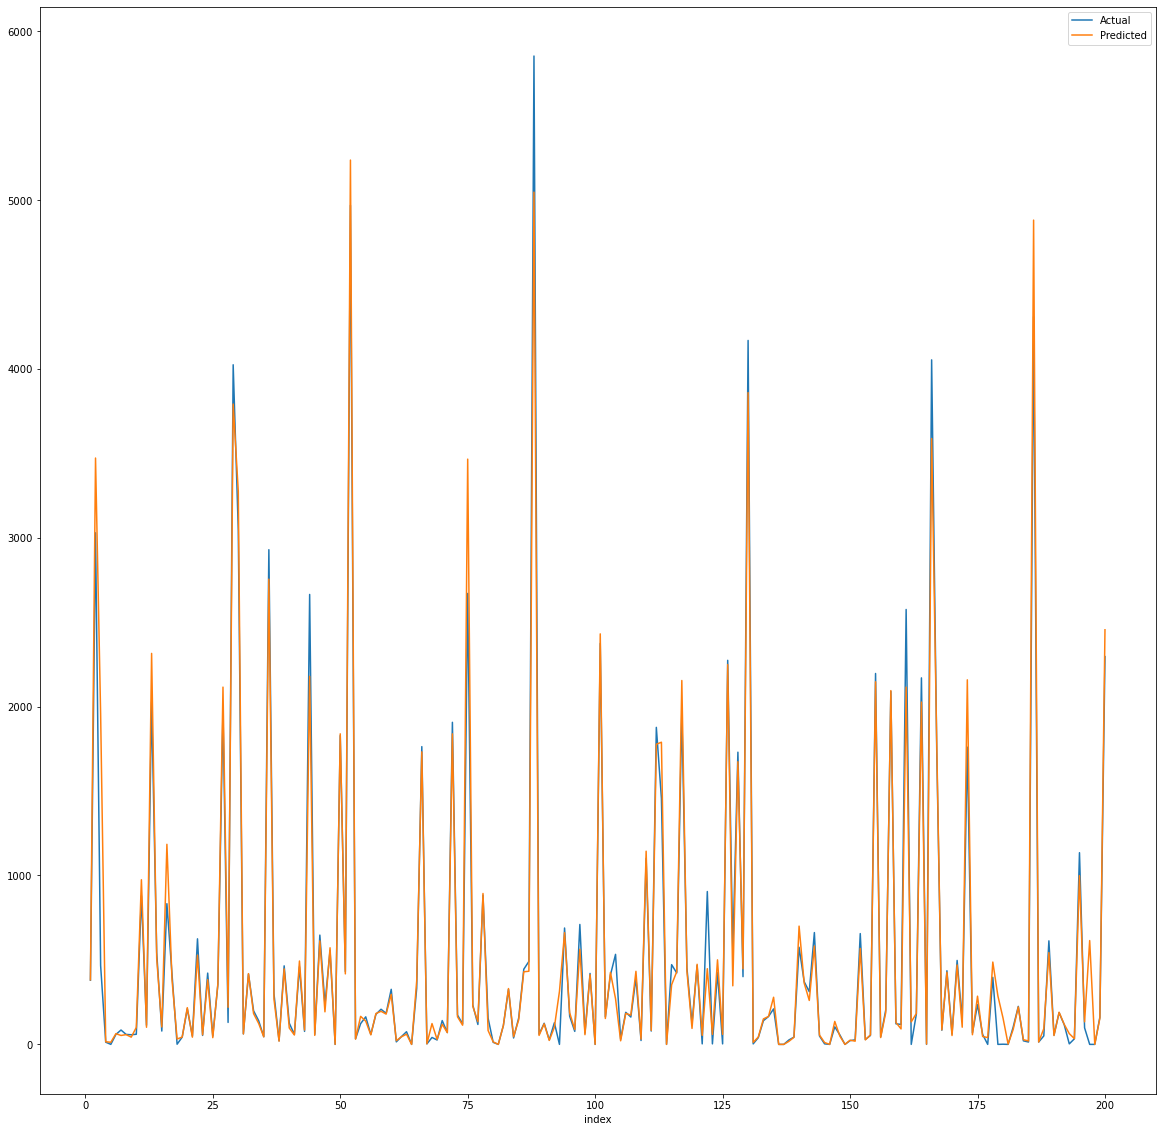

In [58]:
#reducing the amount shown for a better visual
df_dis = df[df['index'] <= 200]
df_dis.plot(x = 'index', figsize = (20, 20))
plt.savefig('images/actualVSpredicted')

This data shows the likely meter readings for the next year

The model seems to have gotten it's prediction very close. Close enough that is a bit hard to tell where the blue line starts and the orange line ends.

As stated earlier, this use case for this is to provide a dataset of predicted meter readings for the next year of any given building so that they may compare it to their current bills after switching to green energy.

This can serve as a point of proof for installers and sellers of green energy (solar, wind, hydro-electric, etc.) that buy items like these help save landlords and tenants money. Not only that but share holders could directly attribute sales incresses to a more convincing sales rep who was given the neccessary info to complete a sale for green energy manufacturers.